In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Step-by-Step Data Preprocessing Demo

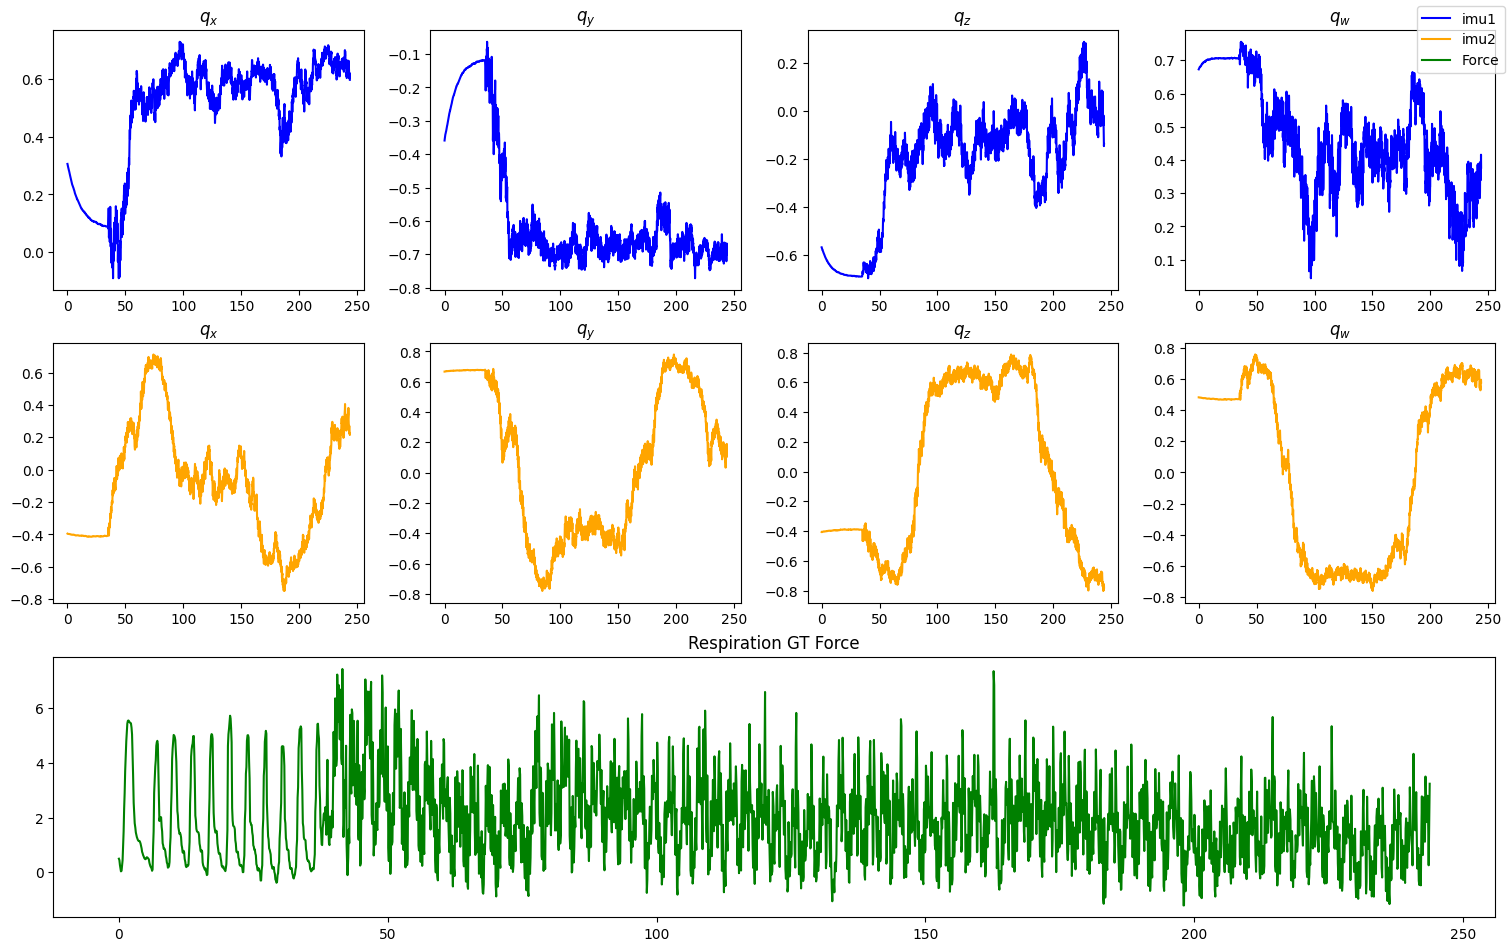

In [4]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

file_path = "./data/hamham/train/run_stand_2.csv"  # ./data/hamham/train/walk_stand_2.csv, ./data/hamham/train/run_stand_2.csv
# file_path = "./data/3_28/walk_stand_0328_0236.csv" 

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=False, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 140/300


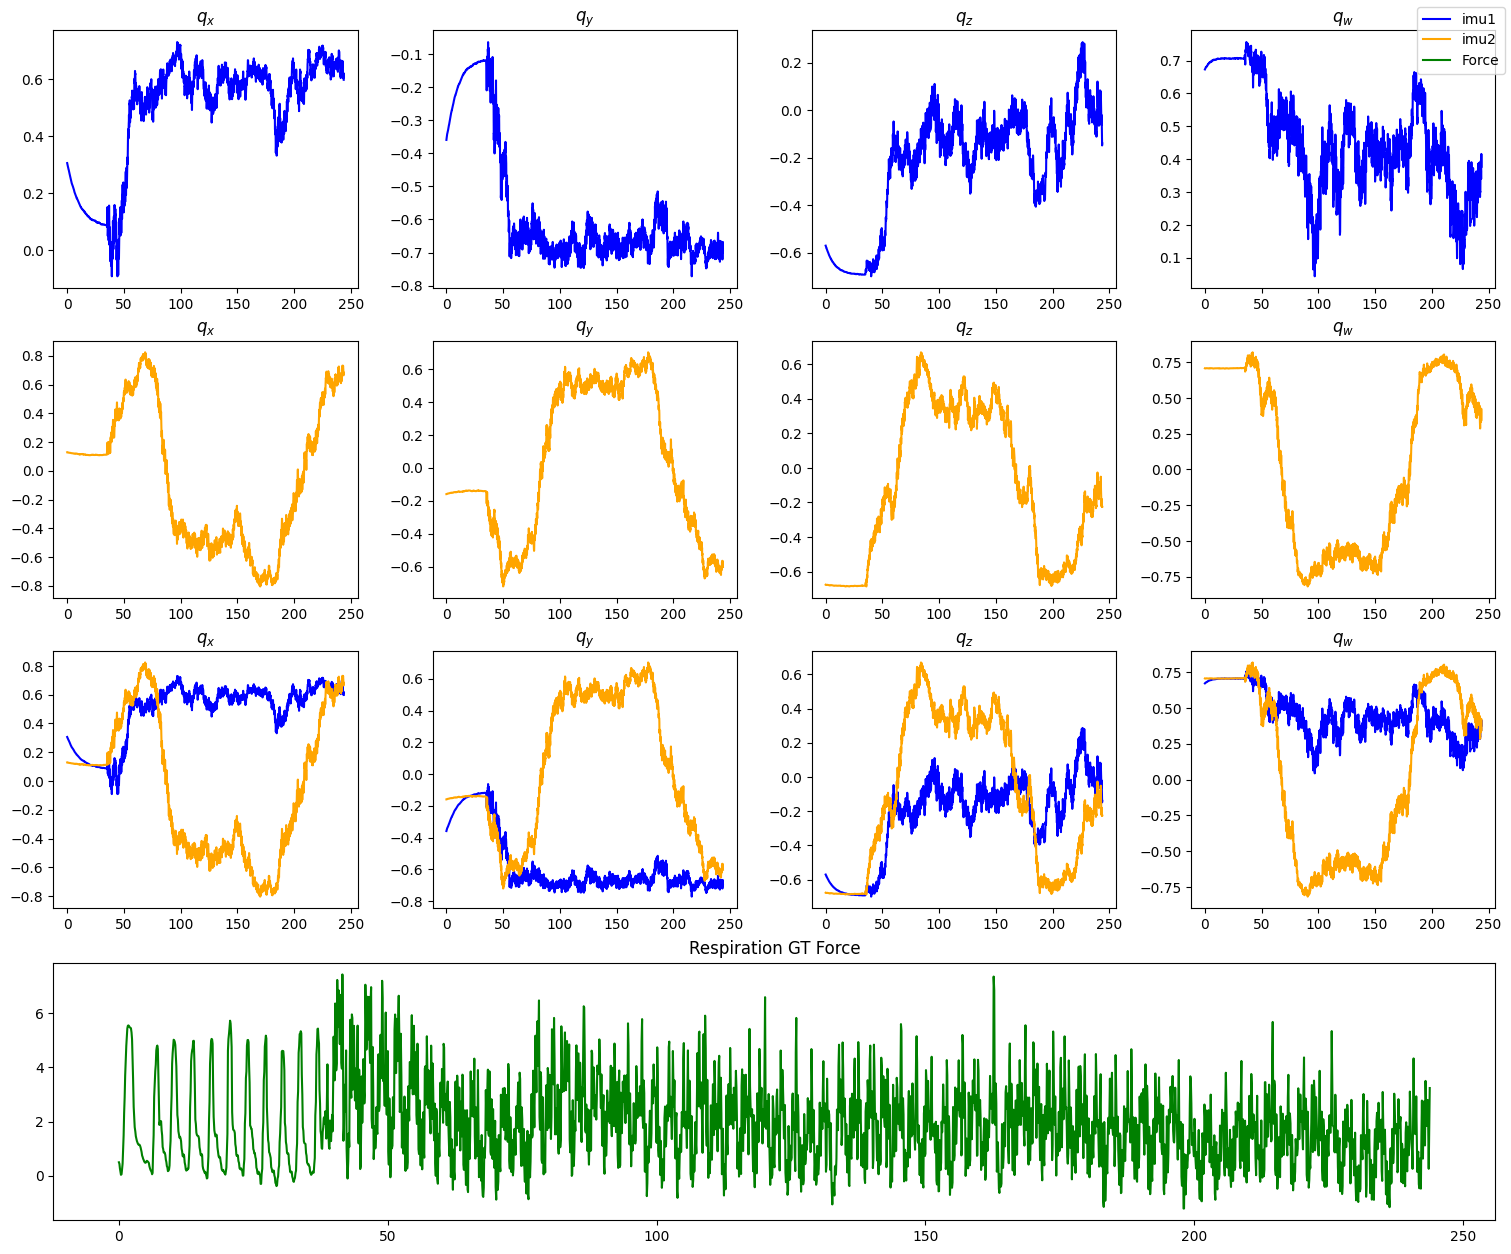

In [5]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

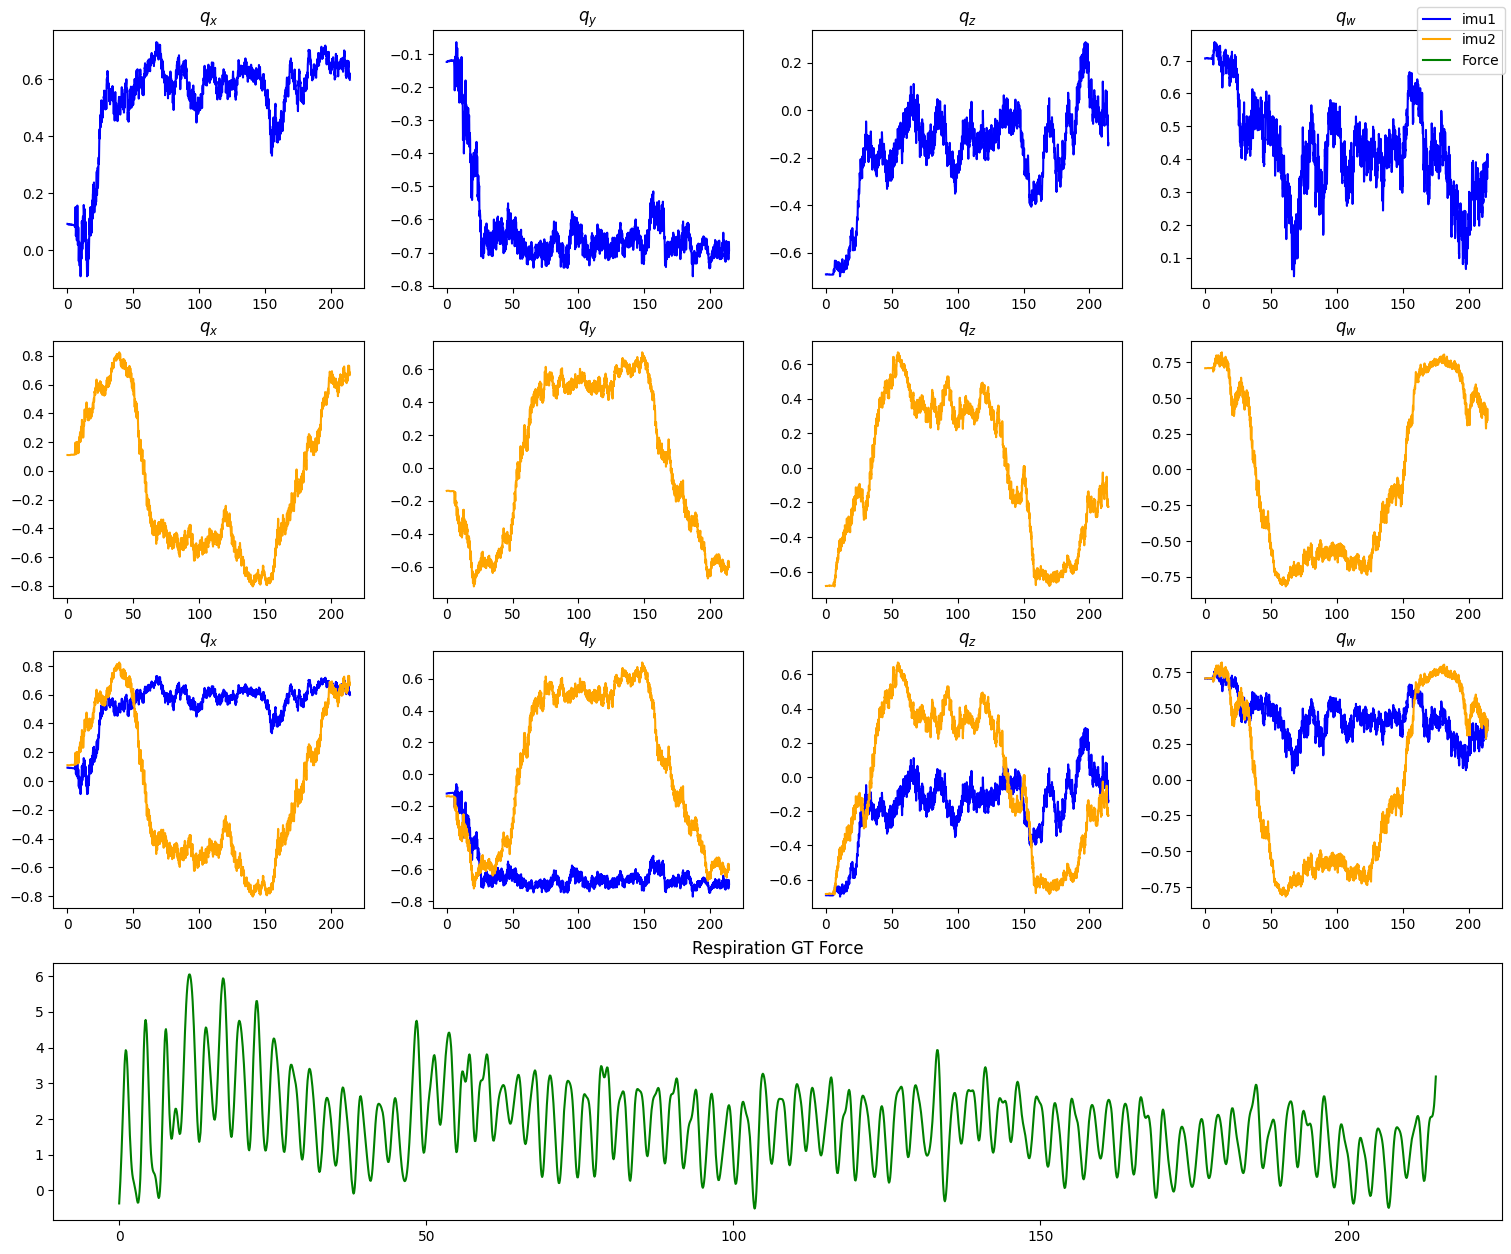

In [6]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [3]:
# file_path = "./data/hamham/train/walk_stand_1.csv" #"./data/hamham/train/walk_stand_2.csv"

file_path = "./data/4_07/sit_0407_0746.csv"

# 1-D spectrogram
window_size=128
stride=64
nperseg=128
noverlap=64
out1=True

# 2-D spectrogram
# window_size=256
# stride=64
# nperseg=128
# noverlap=64
# out1=True

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 300/300
----------------------------
sepctrograms:(40, 16, 65, 1)
gt:(40, 1)
times:(40, 1)


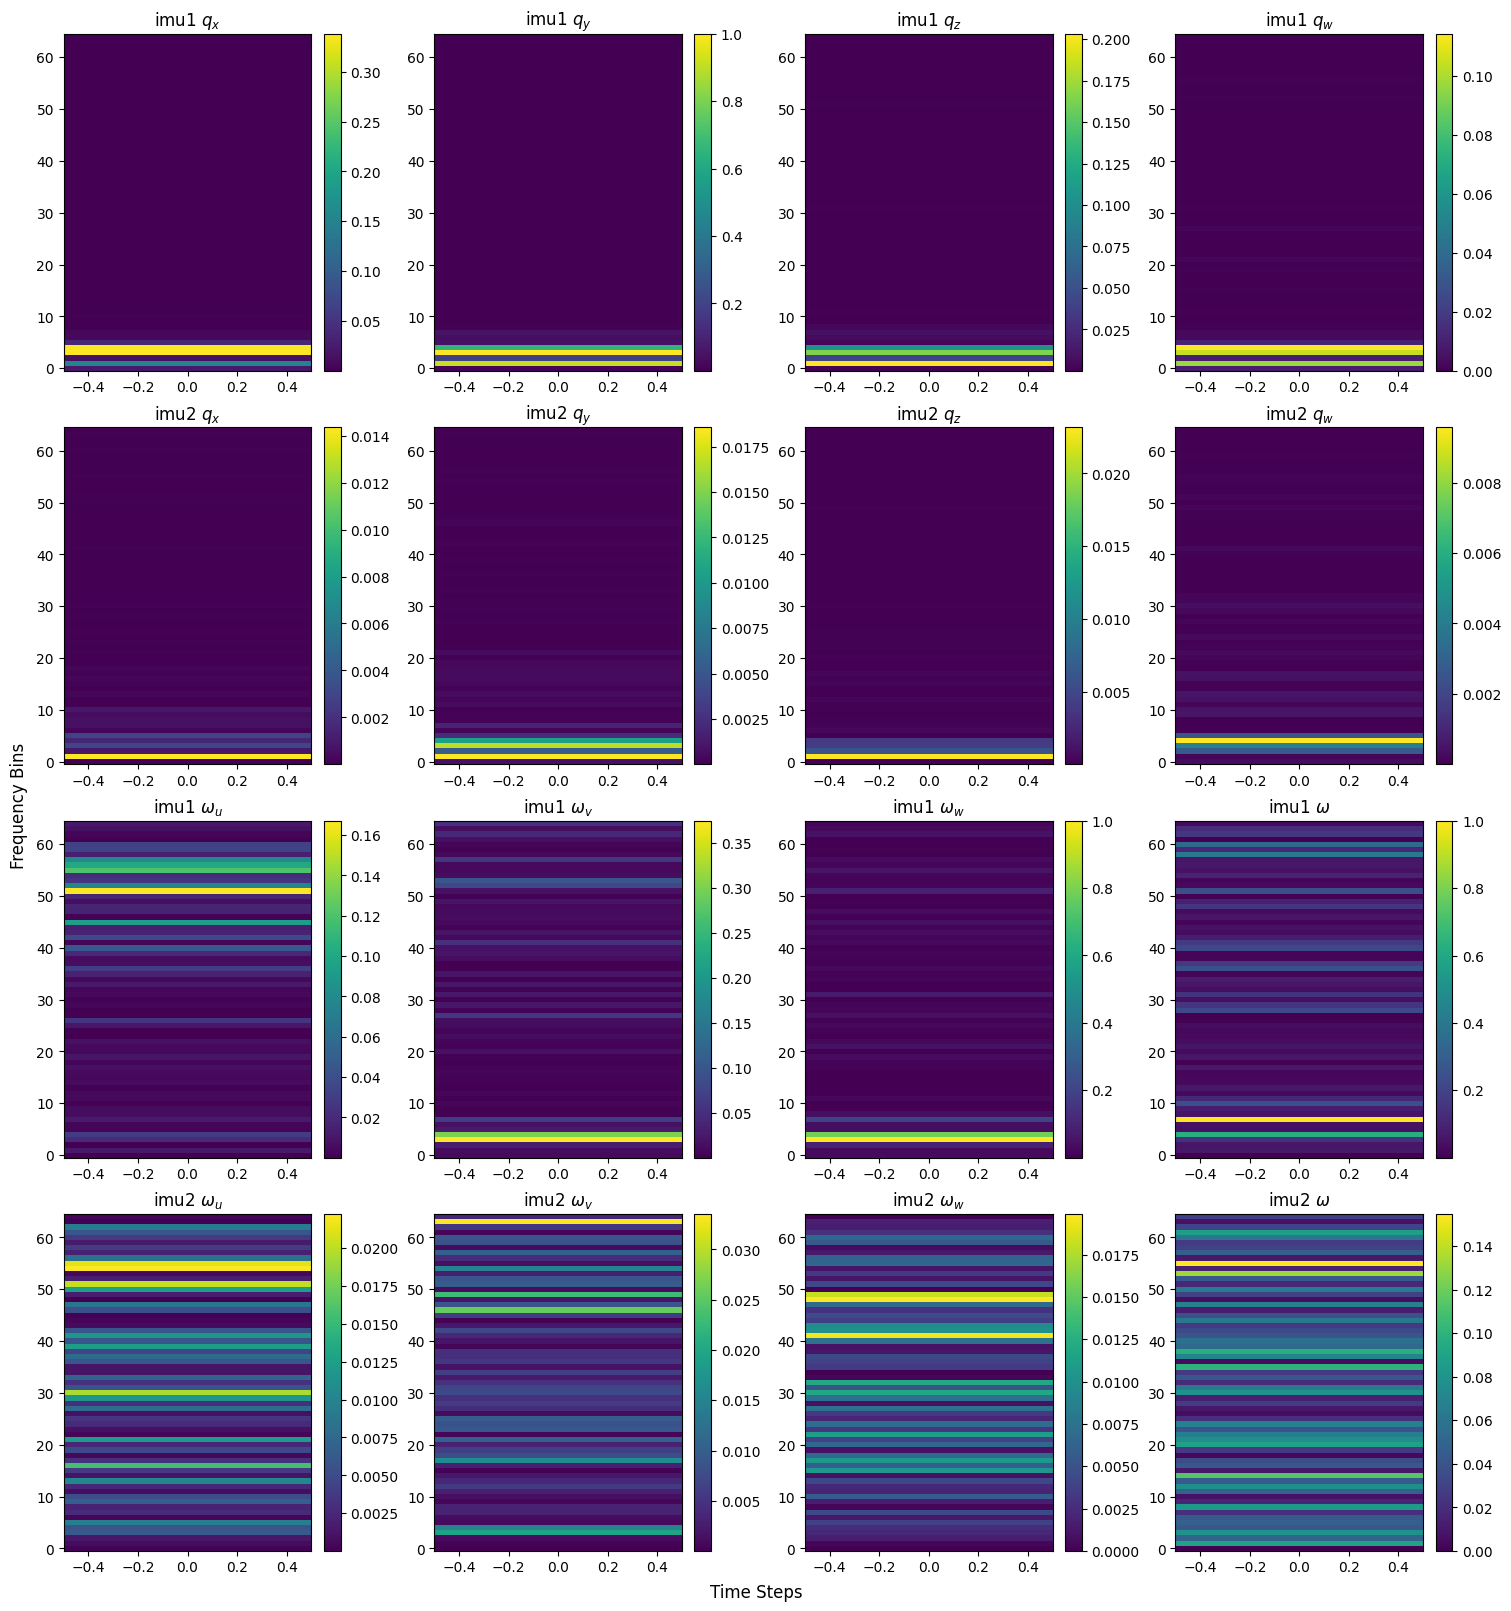

In [4]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[10])

In [8]:
torch.cuda.is_available()

True

## Prepare Dataset

In [9]:
# prepare train, testing dataset
path_train = './data/hamham/train/'
path_test = './data/hamham/test/'
spectrograms_train, gts_train = prepare_data(path_train, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)
spectrograms_test, gts_test = prepare_data(path_test, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)

./data/hamham/train/mix_1.csv
best_score/total: 145/300
./data/hamham/train/mix_2.csv
best_score/total: 215/300
./data/hamham/train/run_stand_1.csv
best_score/total: 51/300
./data/hamham/train/run_stand_2.csv
best_score/total: 140/300
./data/hamham/train/run_stand_4.csv
best_score/total: 59/300
./data/hamham/train/sit_1.csv
best_score/total: 300/300
./data/hamham/train/sit_2.csv
best_score/total: 231/300
./data/hamham/train/sit_4.csv
best_score/total: 300/300
./data/hamham/train/stand_1.csv
best_score/total: 300/300
./data/hamham/train/stand_2.csv
best_score/total: 300/300
./data/hamham/train/stand_4.csv
best_score/total: 300/300
./data/hamham/train/walk_stand_1.csv
best_score/total: 50/300
./data/hamham/train/walk_stand_2.csv
best_score/total: 300/300
./data/hamham/train/walk_stand_4.csv
best_score/total: 187/300
----------------------------
sepctrograms:(484, 16, 65, 3)
gt:(484, 1)
./data/hamham/test/mix_3.csv
best_score/total: 42/300
./data/hamham/test/run_stand_3.csv
best_score/tot

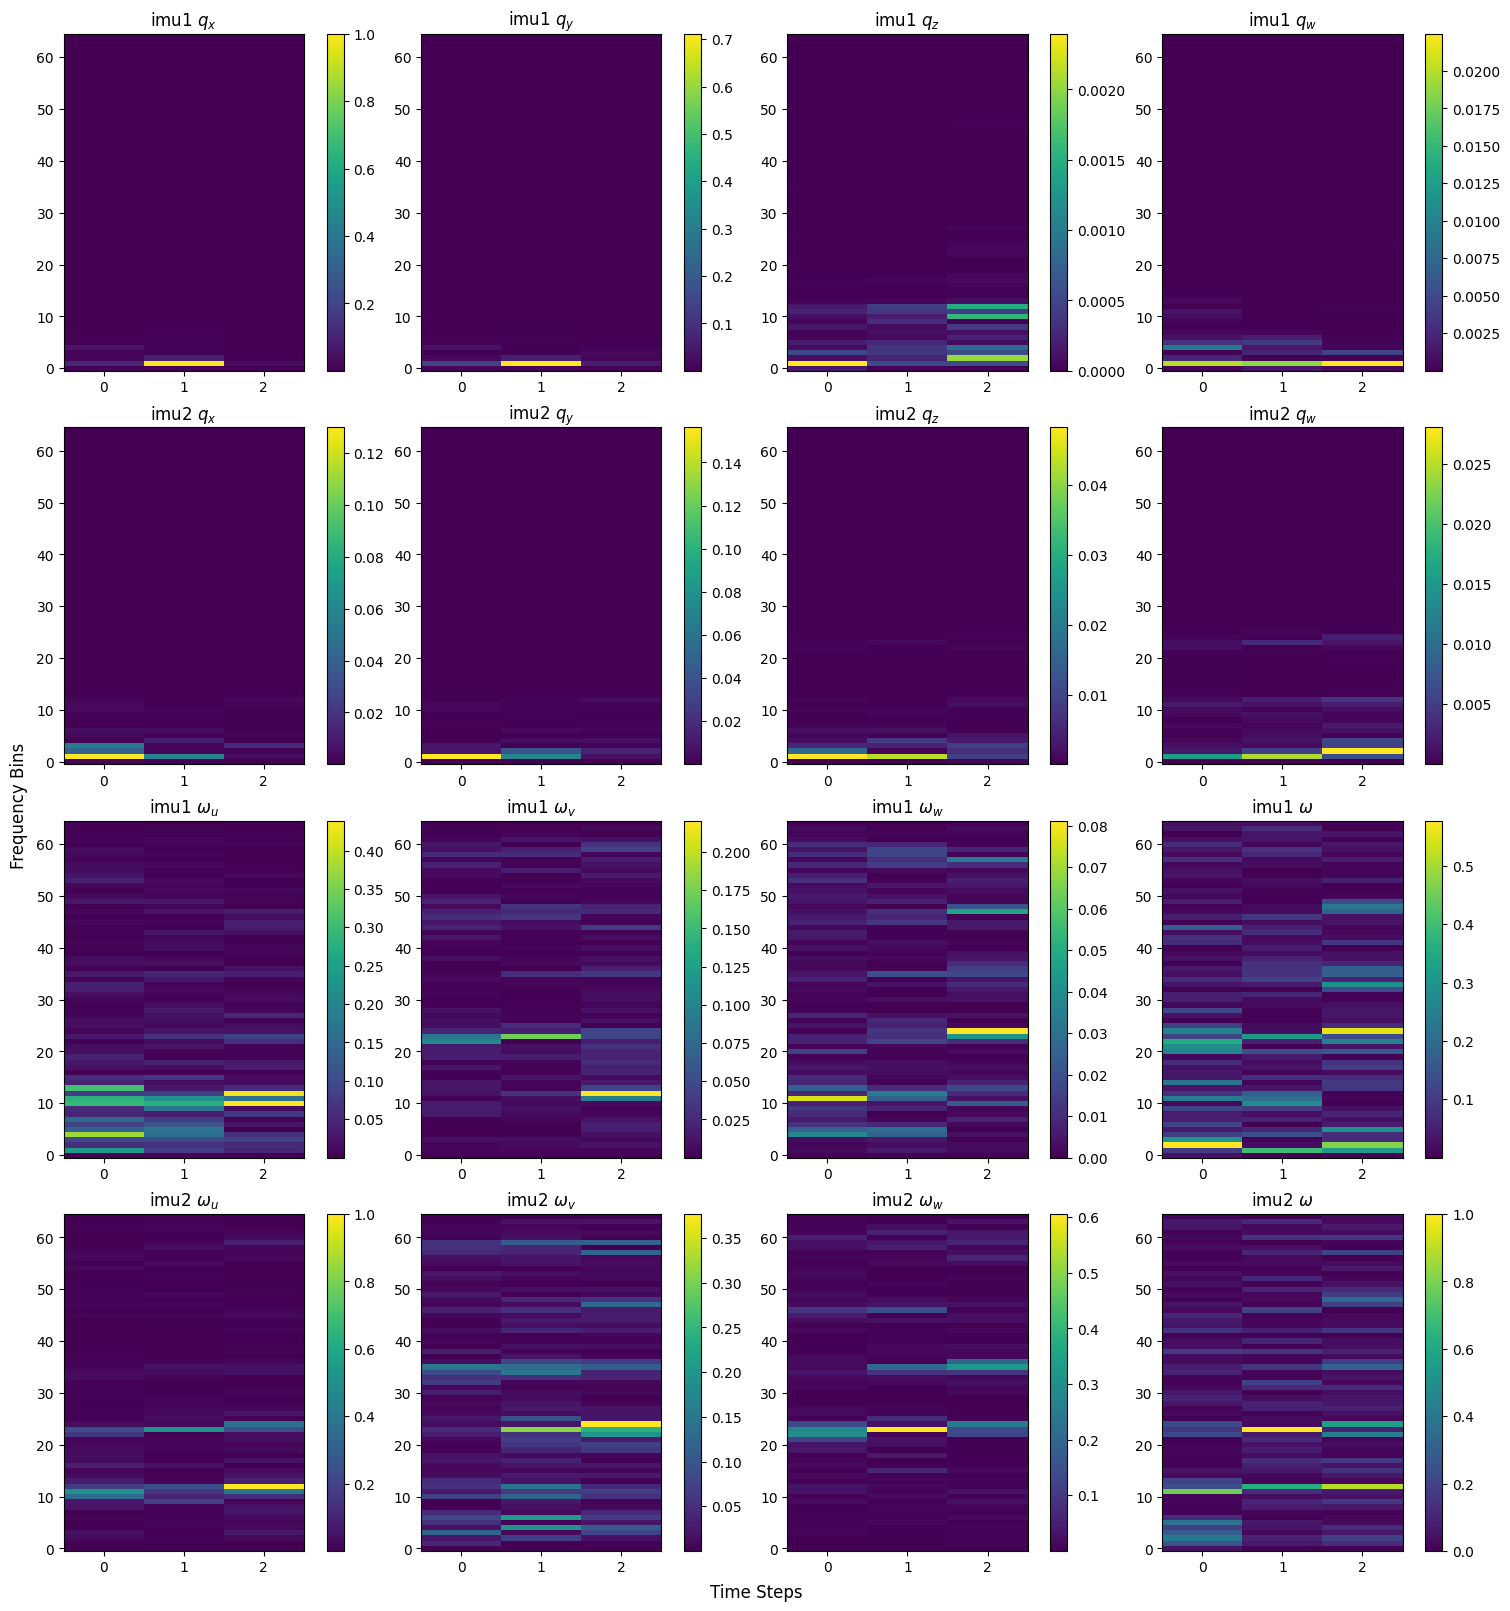

In [13]:
# show one spectrogram
plot_spectrogram_16(spectrograms_train[0])

## Train Model: Spectrogram with MLP

Epoch 1/100, Train MSE: 0.0080, L1: 3.5858, Test MSE: 0.0065, L1: 4.0244
Epoch 2/100, Train MSE: 0.0023, L1: 2.1812, Test MSE: 0.0026, L1: 2.1004
Epoch 3/100, Train MSE: 0.0010, L1: 1.3670, Test MSE: 0.0019, L1: 1.9137
Epoch 4/100, Train MSE: 0.0007, L1: 1.1016, Test MSE: 0.0021, L1: 2.0349
Epoch 5/100, Train MSE: 0.0006, L1: 1.0236, Test MSE: 0.0019, L1: 1.8969
Epoch 6/100, Train MSE: 0.0004, L1: 0.7947, Test MSE: 0.0021, L1: 1.8838
Epoch 7/100, Train MSE: 0.0004, L1: 0.7741, Test MSE: 0.0024, L1: 2.1177
Epoch 8/100, Train MSE: 0.0003, L1: 0.7040, Test MSE: 0.0028, L1: 2.2496
Epoch 9/100, Train MSE: 0.0003, L1: 0.7201, Test MSE: 0.0021, L1: 1.8859
Epoch 10/100, Train MSE: 0.0003, L1: 0.7492, Test MSE: 0.0021, L1: 1.8708
Epoch 11/100, Train MSE: 0.0002, L1: 0.6213, Test MSE: 0.0020, L1: 1.8015
Epoch 12/100, Train MSE: 0.0002, L1: 0.6235, Test MSE: 0.0023, L1: 2.0714
Epoch 13/100, Train MSE: 0.0002, L1: 0.6791, Test MSE: 0.0019, L1: 1.7842
Epoch 14/100, Train MSE: 0.0002, L1: 0.5708, Te

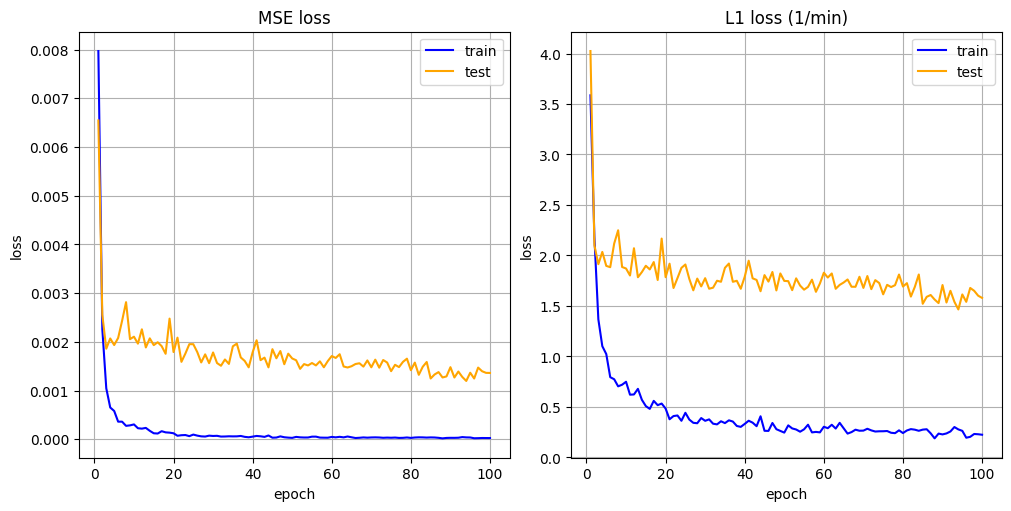

In [14]:
# Load dataset
# spectrograms_train = np.log(spectrograms_train) # log info
dataset_train = IMUSpectrogramDataset(spectrograms_train, gts_train)
dataset_test = IMUSpectrogramDataset(spectrograms_test, gts_test)
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True) # batch_size=16
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True)

# model = MLP(num_freq_bins, num_time_steps, num_channels=num_channels)
model = MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = CNN_1D_2(num_channels=num_channels)
# model = CNN_out1_2(num_channels=num_channels)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now = datetime.now()
model_name = now.strftime("%m%d_%H.%M.%S") # MM_DD_HH:mm:ss
train_model(model, train_loader, test_loader, num_epochs=100, name=model_name, device=device, visualize=True)

## Testing Model

In [5]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "hamham_16_1D" # hamham, hamham_out1, hamham_16_1D, hamham_16_2D
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

# Load model
model_name = 'MLP_16_1D' # MLP_1D, CNN_1D, MLP_out1,  CNN_out1, MLP_16_1D, CNN_16_1D_2, MLP_16_2D, CNN_16_2D_2
model = MLP(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels)
# model = CNN_1D_2(num_channels=num_channels)
# model = CNN_out1_2(num_channels=num_channels)

model.load_state_dict(torch.load(f'./models/{str(model_name)}.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model in whole testing set
mse, mae = evaluate_model(model, test_loader, device=device)

Testing data......
Testing shape: (347, 16, 65, 1)
model Evaluation Results - MSE Loss: 0.0014, L1 Loss: 1.6624 1/min


In [15]:
# Test one file
# action_name = "walk_stand_0407_0852"
action_name = "stand_5"
# sit_3, stand_3, walk_stand_3, run_stand_3
# sit_5, stand_5, walk_stand_5, run_stand_5, mix_3
path_file = f'./data/hamham/test/{action_name}.csv'
# path_file = f"./data/4_07/{action_name}.csv"


# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 300/300
----------------------------
sepctrograms:(40, 16, 65, 1)
gt:(40, 1)
times:(40, 1)


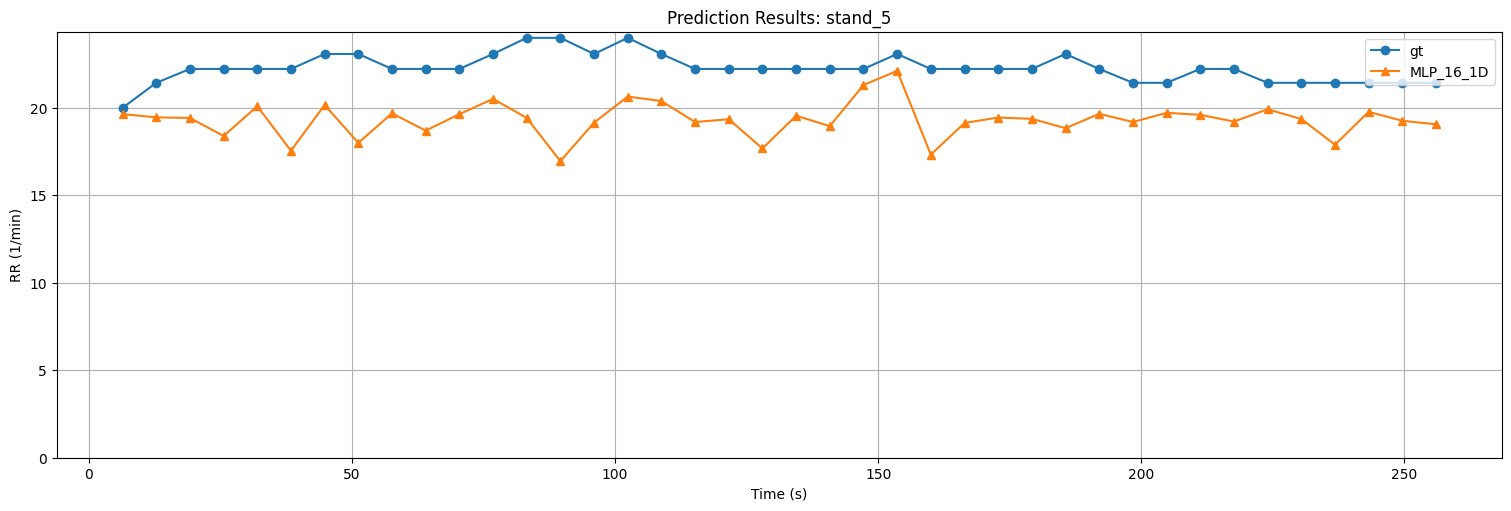

Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.9547 1/min


In [16]:
avg_mse_loss, avg_l1_loss, preds = evaluate_model_file(model, file_loader, model_name=model_name,gt=gts_file, times=times_file, action_name=action_name)

In [17]:
# Load models
# 1-D spectrogram
models_name = ['MLP_16_1D', 'CNN_16_1D_2']
models = [MLP(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_1D_2(num_channels=num_channels)]

# 2-D spectrogram
# models_name = ['MLP_16_2D', 'CNN_16_2D_2']
# models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
#           CNN_out1_2(num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_16_1D Evaluation Results - MSE Loss: 0.0014, L1 Loss: 1.6624 1/min
CNN_16_1D_2 Evaluation Results - MSE Loss: 0.0019, L1 Loss: 1.9795 1/min


MLP_1D Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.9547 1/min
CNN_1D Evaluation Results - MSE Loss: 0.0041, L1 Loss: 3.4768 1/min


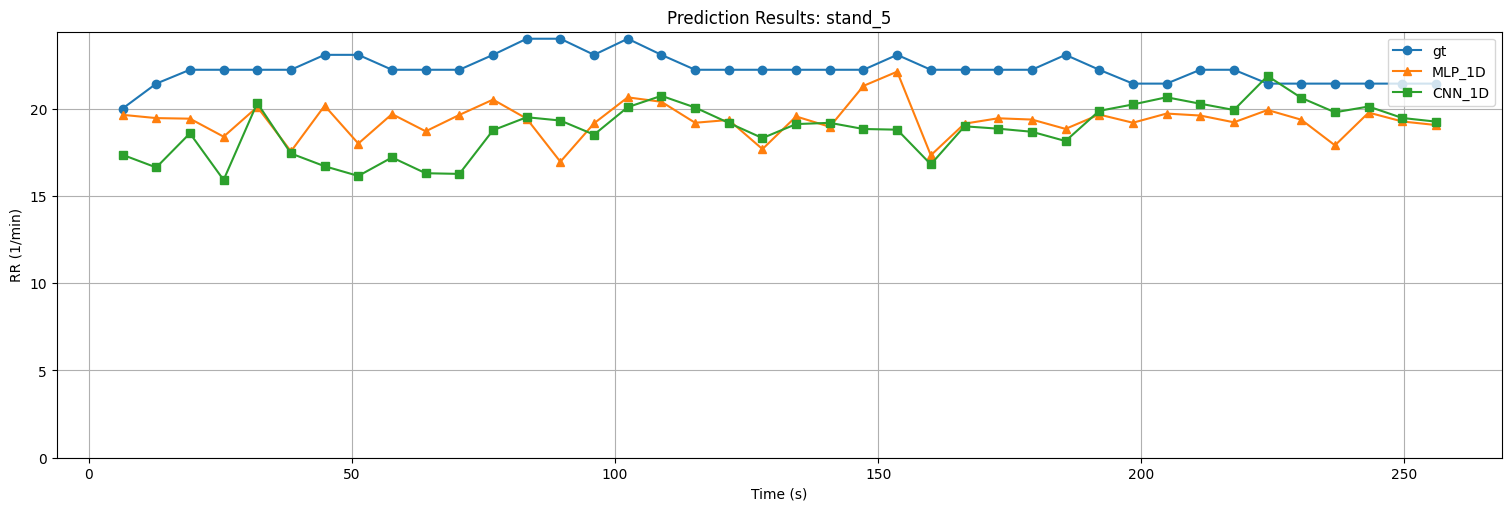

In [18]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_1D", "CNN_1D"], gt=gts_file, times=times_file, action_name=action_name)
# avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_2D", "CNN_2D"], gt=gts_file, times=times_file, action_name=action_name)